In [1]:
import tensorflow as tf

# Configurar la GPU antes de inicializar TensorFlow
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#print(physical_devices)

2024-03-27 17:20:23.557467: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-03-27 17:20:25.511750: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-27 17:20:25.512329: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-03-27 17:20:25.523399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-27 17:20:25.523513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.425GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2024-03-27 17:20:25.523530: I tensorflow/stream_executor/

In [ ]:
from tensorboard import program

log_dir = "./home/vicevil/Documentos/graficas/logs"
tb=program.TensorBoard()
tb.configure(argv=[None, '--logdir', log_dir])
url = tb.launch() #  lanza TensorBoard en el navegador

import tensorboard

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.sparse import hstack
import funciones_ML as bt
from sklearn.feature_extraction.text import TfidfVectorizer, FeatureHasher
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, Normalizer,MaxAbsScaler
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay,classification_report,r2_score,RocCurveDisplay,confusion_matrix, accuracy_score,recall_score,f1_score,precision_score,precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, SGDClassifier, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,ReduceLROnPlateau,CallbackList
from tensorflow.keras.regularizers import l2, l1, l1_l2
from sklearn.cluster import KMeans
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras import regularizers
from sklearn.compose import ColumnTransformer
from tensorflow.keras.losses import CategoricalCrossentropy, sparse_categorical_crossentropy, binary_crossentropy
import networkx as nx
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau





# Configurar pandas para mostrar todas las filas y columnas
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Código para los tamaños de las fuentes y los "ticks" de los ejes:
plt.rc('font', size=6)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

APLICACION RED NEURONAL AL DATASET LIMPIO MENOS LAS 3 TRAS EL ESTUDIO DE CORRELACION

In [4]:
df=pd.read_csv(r"/home/vicevil/Documentos/df_malware_unido_solo_cat_y_escalar.csv")

In [5]:
df.drop(columns={"dia","resp_ip_bytes", "orig_ip_bytes"}, inplace=True)

In [11]:
df.shape

(25011003, 13)

In [6]:
df_mix=df.copy()
df_round=df.copy()
df_hash=df.copy()

In [12]:
df_hash.shape

(25011003, 13)

APLICACION TECNICAS LABELENCODER Y MINMAX

In [14]:
#minmax sin redondear
scaler= MinMaxScaler()
array_sca=scaler.fit_transform(df_mix)

In [15]:
df_minmax=pd.DataFrame(array_sca)

In [7]:
 #Itera sobre las columnas categóricas(LABEL-ENCONDER)
for col in df_round.columns[df_round.dtypes == 'object']:  
    cat = LabelEncoder()
    df_round[col] = cat.fit_transform(df_round[col]) 

In [25]:
for col in list(df.select_dtypes(include=['category', 'object'])):
    print(f"Columna {col}: {df[col].dtype}")

Columna id.resp_h: object
Columna proto: object
Columna conn_state: object


HASH TRICK

In [28]:

cols_categoricas = list(df.select_dtypes(include=['category', 'object']))

# Convierte columnas a string
for col in cols_categoricas:
    df[col] = df[col].astype(str) 

#Aplico  el Hashing Trick
hasher = FeatureHasher(n_features=3, input_type="string")
df_hash = hasher.fit_transform(df[cols_categoricas]) 

MINMAX MAS REDONDEO A 1 Y 0

In [8]:
#minmax redodenando a numeros enterros 0 y 1
columnas_numericas = df_round.drop(["Target"], axis=1).select_dtypes(include=['number'])
#instacio
scaler = MinMaxScaler()

# Escalo datos
col_num_scal = scaler.fit_transform(columnas_numericas)

# rangos que queremos
rango_deseado_min = 0
rango_deseado_max = 1

# Multiplica los datos x los rangos
col_num_scal_rangos= col_num_scal * (rango_deseado_max - rango_deseado_min) + rango_deseado_min

# Redondea los datos escalados rescalados al entero más cercano
col_num_scal_round = pd.DataFrame(col_num_scal_rangos).round().astype(int)

# Concatena los datos rescalados enteros con la columna "Target" y el resto del DataFrame original
df_round = pd.concat([df_round["Target"], col_num_scal_round], axis=1)


APLICACION RED NEURONAL

In [ ]:
df_minmax=pd.read_csv("/home/vicevil/Documentos/df_malware_unido_label_minmax_neuronal.csv")

In [16]:
df_minmax

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.786206,0.836806,0.000351,0.5,0.500000,0.0,4.543571e-08,0.000000,0.0,0.363636,0.652174,0.333333,0.0
1,0.859159,0.829254,0.000351,0.5,0.500000,0.0,1.514524e-08,0.000000,0.0,0.363636,0.652174,0.333333,0.0
2,0.627161,0.062841,0.000351,0.5,0.500000,0.0,1.514524e-08,0.000000,0.0,0.363636,0.652174,0.333333,0.0
3,0.929351,0.170226,0.000351,0.5,0.500000,0.0,4.543571e-08,0.000000,0.0,0.363636,0.652174,0.333333,0.0
4,0.675990,0.959768,0.000351,0.5,0.500000,0.0,1.514524e-08,0.000000,0.0,0.363636,0.652174,0.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25010998,0.001877,0.946989,0.001877,1.0,0.833333,0.0,3.029048e-08,0.000208,1.0,0.727273,0.000000,0.833333,1.0
25010999,0.569253,0.014160,0.271138,0.5,0.583333,0.0,1.355802e-04,1.000000,1.0,0.727273,0.043478,0.666667,0.0
25011000,0.001877,0.626815,0.001877,1.0,0.833333,0.0,3.029048e-08,0.000208,1.0,0.727273,0.000000,0.833333,1.0
25011001,0.001877,0.779650,0.001877,1.0,0.833333,0.0,3.029048e-08,0.000208,1.0,0.727273,0.000000,0.833333,1.0


In [4]:
df_round=pd.read_csv(r"/home/vicevil/Documentos/df_malware_unido_lb_mm_round_neuronal.csv")

In [5]:
df_round.drop(columns={"Unnamed: 0"}, inplace=True)

In [6]:
df_round

,Target,0,1,2,3,4,5,6,7,8,9,10,11
0,0,1,1,0,0,0,0,0,0,0,0,1,0
1,0,1,1,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,1,0
4,0,1,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25010998,1,0,1,0,1,1,0,0,0,1,1,0,1
25010999,0,1,0,0,0,1,0,0,1,1,1,0,1
25011000,1,0,1,0,1,1,0,0,0,1,1,0,1
25011001,1,0,1,0,1,1,0,0,0,1,1,0,1


In [7]:
X=df_round.iloc[:,1:12]
y=df_round["Target"]

In [8]:
X_train, X_test, y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

Convierto todo en Arrays

In [9]:
X_train_a=X_train.values
X_test_a = X_test.values
y_train_a=y_train.values
y_test_a=y_test.values

In [10]:
X_train_a.shape

(20008802, 11)

In [11]:
# Definir el directorio de registro para TensorBoard(ensorBoard es una herramienta esencial para entender, depurar y optimizar los modelos de TensorFlow.)
log_dir = r"/home/vicevil/Documentos/graficas/logs"

1. MODELO NEURONAL SECUANCIAL
    - el modelo se compone de 4 capas bidimensionales de entrada junto a 4 capas densas en sentido decreciente y alternando activaciones relu y elu, que impiden la muerte neuronal. Despues de la concatenacion de las capas, el modelo continua con 4 capas densas con la mismas caracteristicas que las anteriores, a excepcion de la capa de entrada, que llega un regularizador l2 para controlar el sobreajuste y detras de cada capa densa hay una capa batchnormalization que mejora la tasa de aprendizaje, evitando el sobreajuste y ayudando a la regularizacion, fiinalizando con unca capa de salida de 2 unidades yu activacion sotfmax para clasificacion.
    Al modelo le acompaña un early_stopping, para evitar el sobreajuste si se repite 5 veces el mismo valor y un reduce_lr, el cual reduce la tasa de aprendizaje cuando el conjunto de validacion no mejora

In [12]:
import os
#habilita la aceleracion por hardware de mi grafica
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla=true"

In [13]:
%load_ext tensorboard

In [14]:
modelo = tf.keras.Sequential()
# Definir las 4 entradas
 
modelo.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(11,), kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

# Capas ocultas
modelo.add(tf.keras.layers.Dense(units=128, activation="relu", input_dim=11))
modelo.add(tf.keras.layers.BatchNormalization())

modelo.add(Dropout(0.2))

modelo.add(tf.keras.layers.Dense(units=64, activation="elu"))
modelo.add(tf.keras.layers.BatchNormalization())

modelo.add(tf.keras.layers.Dense(units=32, activation='elu'))
modelo.add(tf.keras.layers.BatchNormalization())

# Capa de salida
modelo.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # Se cambia a 2 unidades para representar las dos clases
#optimizador
"""optimizador= tf.keras.optimizers.SGD(learning_rate=0.005,
                                      momentum=0.9, #aporta inercia al proceso de optimizacion, acelerando la convergencia
                                      nesterov=True)# en True actualiza momentum demanera anticipada al gradiente, mejorando la estaboiilidad"""

optimizador=Adam( learning_rate=0.01, # rebajo el learning rate por ser mas adecuado para un ajuste fino aunque tarde mas
                    beta_1=0.6, # influye en el gradiente pasado (1 mas al gradiente y 0 nada)
                    beta_2=0.4, #influye en los cuadrados de los gradientes pasados(1 mas a la varianza y 0 nada)
                    epsilon=1e-09, #es para prevenior divisiones entre 0
                    amsgrad=True)#es una variante de Adam y ayuda con la convergencia de ambos a evitar oscilaciones de los pesos durante la optimizacion"""
"""optimizador = tf.keras.optimizers.Ftrl(
    l1_regularization_strength=0.0001,#penaliza los pesos con lasso
    l2_regularization_strength=0.000001,#penaliza con ridge, consiguiendo con ambos un proceso de actualziacion de pesosmejorado, evitando sobreajuste
    learning_rate_power=-0.5,#contola la rapidez de la tasa de aprendizaje con la que decae con el tiempo, indiviualemnte a cada parametro
    initial_accumulator_value=0.1,#valor inicial de acumulacion de gradientes
)"""

# Compilar el modelo
modelo.compile(optimizer=optimizador, loss=binary_crossentropy, metrics=['accuracy'])

#detniene el entrenamiento si la metrica no mejora 
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

#reduce la tasa de aprendizaje cuando el rendimiento del conj. val no mejora
reduce_lr_callbacks = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)

#Guarda el modelo cuando mejora la métrica de validación
filepath = '/home/vicevil/Documentos/graficas/logs/fit/modelo.h5'
monitor = 'val_loss'
checkpoint_callbacks = ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=1, save_best_only=True)

#visionado tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)


callbacks_list = [reduce_lr_callbacks, early_stopping_callbacks, tensorboard_callback, checkpoint_callbacks]

# Entrenar el modelo
historia = modelo.fit(X_train, y_train, batch_size=128, epochs=20,verbose=1,validation_split=0.1,callbacks=callbacks_list)

2024-03-27 17:22:27.055560: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 17:22:27.055866: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-27 17:22:27.056001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-27 17:22:27.056131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.425GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwid

Epoch 1/20


2024-03-27 17:22:32.902308: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


    56/140687 [..............................] - ETA: 9:22 - loss: 0.5545 - accuracy: 0.7970 

2024-03-27 17:22:33.807054: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-03-27 17:22:33.807080: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-03-27 17:22:33.807738: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2024-03-27 17:22:33.813975: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-03-27 17:22:33.818238: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-03-27 17:22:33.819943: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-03-27 17:22:33.824201: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /home/vicevil/Documentos/graficas/logs/tra

140687/140687 [==============================] - 366s 3ms/step - loss: 0.3267 - accuracy: 0.8244 - val_loss: 0.3228 - val_accuracy: 0.8264

Epoch 00001: val_loss improved from inf to 0.32279, saving model to /home/vicevil/Documentos/graficas/logs/fit/modelo.h5
Epoch 2/20
140687/140687 [==============================] - 363s 3ms/step - loss: 0.3235 - accuracy: 0.8253 - val_loss: 0.3225 - val_accuracy: 0.8264

Epoch 00002: val_loss improved from 0.32279 to 0.32245, saving model to /home/vicevil/Documentos/graficas/logs/fit/modelo.h5
Epoch 3/20
140687/140687 [==============================] - 360s 3ms/step - loss: 0.3231 - accuracy: 0.8257 - val_loss: 0.3226 - val_accuracy: 0.8264

Epoch 00003: val_loss did not improve from 0.32245
Epoch 4/20
140687/140687 [==============================] - 360s 3ms/step - loss: 0.3231 - accuracy: 0.8256 - val_loss: 0.3228 - val_accuracy: 0.8264

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00004: val_loss did not

In [15]:

modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                2

In [16]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = modelo.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

# Predicción
y_pred = modelo.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas de clasificación
print(classification_report(y_test, y_pred_classes))

156319/156319 [==============================] - 139s 888us/step - loss: 0.3225 - accuracy: 0.8264
Loss: 0.3224889636039734
Accuracy: 0.8263800144195557


/home/vicevil/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vicevil/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79   3245538
           1       0.00      0.00      0.00   1756663

    accuracy                           0.65   5002201
   macro avg       0.32      0.50      0.39   5002201
weighted avg       0.42      0.65      0.51   5002201



/home/vicevil/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


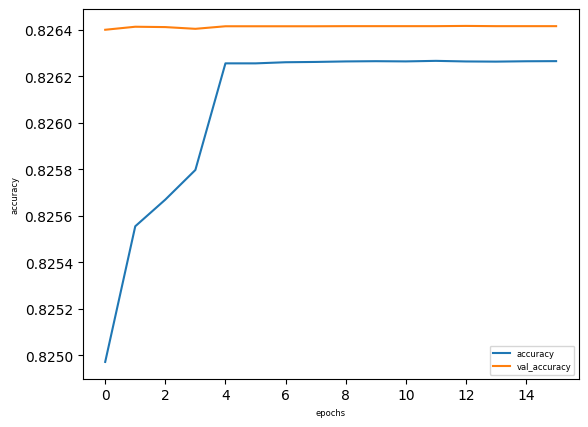

In [17]:
df_history = pd.DataFrame(historia.history)
df_history[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

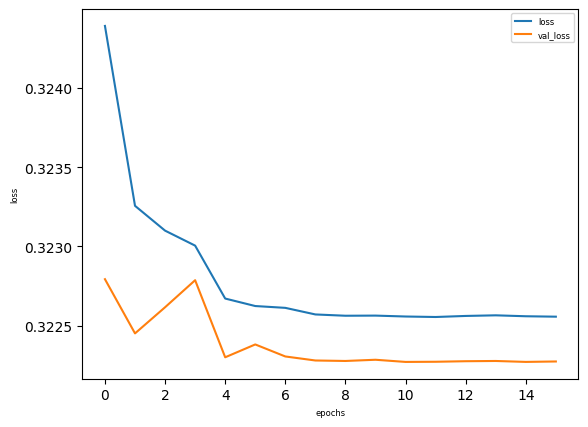

In [18]:
df_history = pd.DataFrame(historia.history)
df_history[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");